Data Science By Rithvik Mandumula
# Applying neural networks to an image-recognition task: recognizing handwritten digits.



In [ ]:
from datascience import *
import numpy as np

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plots

For this project, I will be using a famous benchmark dataset, the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database). This dataset consists of 70,000 images of handwritten digits (see a sample [here](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)), which have all been manually labeled with numbers from 0 to 9.

To load this dataset, I used a built-in function from the scikit-learn library, `fetch_openml`, which will retrieve the dataset from an online repository and then store the features and corresponding labels in two NumPy arrays, `X_raw` and `y_raw`:

In [ ]:
from sklearn.datasets import fetch_openml
X_raw, y_raw = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

# Part 1: Data Exploration

Before attempting to train any models, let's investigate the dataset that we just loaded. First, let's take a look at the feature values `X_raw`, which are stored in an array:

In [ ]:
X_raw

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

A bunch of zeros... not very helpful. Let's take a look at the shape of the array `X_raw`:

In [ ]:
X_raw.shape

(70000, 784)

We see two values, indicating that `X_raw` is a two-dimensional array, that is, an array of arrays. The first number is 70,000, which is the number of examples in the dataset. The second number is 784, which is the number of features. That is a lot of features!

We will get back to these features soon, but before that, let's take a look at the label values `y_raw`:

In [ ]:
y_raw

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

We can see numbers, ranging from 0 to 9. This make sense since the dataset consists of handwritten digits (0-9). We can also take a look at the shape of the array `y_raw`:

In [ ]:
y_raw.shape

(70000,)

We see that `y_raw` is a simple, one-dimensional array: one label value for each example.

Now, let's get back to the features. First, let's display the feature values of the first example in the dataset (note that in Python, arrays are indexed starting from 0, so the index of the first example is 0):

In [ ]:
X_raw[0]

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,

We see a bunch of numbers, which are mostly zero, with a few larger values scattered around. What is the meaning of this?

The numbers that we see above are **image data**, which is not easy for humans to read in their raw form. The data will make much more sense if we display the first example `X_raw[0]` as an image:

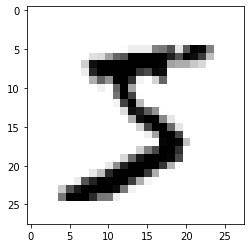

In [ ]:
plots.imshow(X_raw[0].reshape(28, 28), cmap='binary')
plots.show()

Nice. This looks like the digit 5. We can also check the corresponding label to be sure:

In [ ]:
y_raw[0]

'5'

Okay, the label also says 5.

So, how is the above image represented by 784 features? To answer this, we need to understand the basics of how digital images are stored by computers, phones, etc. The most common way to represent 2D images digitally is using [raster graphics](https://en.wikipedia.org/wiki/Raster_graphics) (e.g., JPEG and PNG files, but even video frames). A raster graphic represent a 2D image as a rectangular grid of square pixels. Each small square in the above image is one pixel. 

You may have noticed that our image looks "blocky" (i.e., like Minecraft). The reason for this is that our image consists of only 28 by 28 pixels (28 rows and 28 columns), and each pixel is a uniformly colored square.

The image data `X_raw[0]` specifies the color of each pixel: 28 rows by 28 columns = 28 * 28 = 784 pixels. The 784 features specify the colors of the 784 pixels.

Finally, let's look at the individual feature values, which are supposed to represent colors:

In [ ]:
print("Pixel values")
print("Minimum:", np.min(X_raw))
print("Mean:", np.mean(X_raw))
print("Maximum:", np.max(X_raw))
print("Std.dev.:", np.std(X_raw))

Pixel values
Minimum: 0.0
Mean: 33.3859647413
Maximum: 255.0
Std.dev.: 78.6543736269


We see that feature values range from 0 to 255, and most values are 0 (or close to 0).

You may have also noticed that our image is grayscale: it has only black, white, and various shades of gray in between. This simplifies the representation since for each pixel, we need to store only its brightness, which can be represented by a single number. In this dataset, 0 represents white, 255 represents black, and values in between represent gray pixels (lower values being brighter, and higher values being darker).


Displaying the first 10 images in the dataset and their corresponding label ⬇⬇⬇⬇



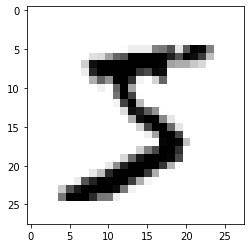

Label: 5


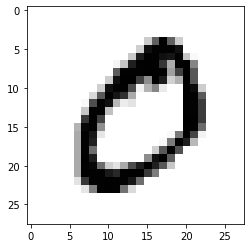

Label: 0


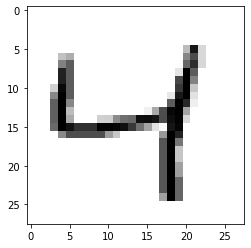

Label: 4


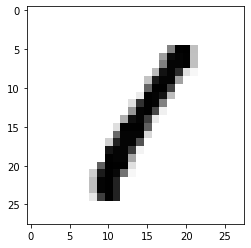

Label: 1


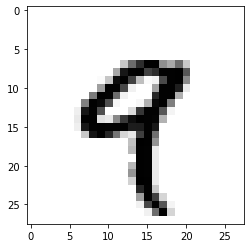

Label: 9


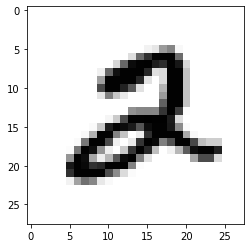

Label: 2


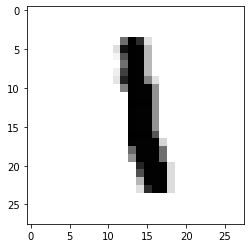

Label: 1


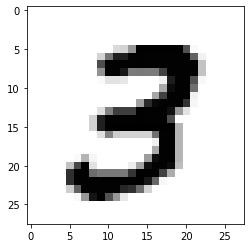

Label: 3


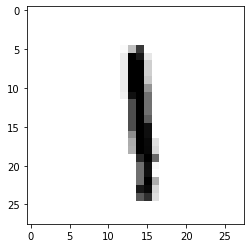

Label: 1


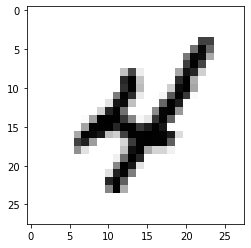

Label: 4


In [ ]:
for i in np.arange(10):
  plots.imshow(X_raw[i].reshape(28, 28), cmap='binary')
  plots.show()
  print('Label: ' + y_raw[i])

  


# Part 2: Preparation of Training and Test Sets

Now that we are familar with the dataset, let's start preparing it for training. First, we need to normalize the feature values (this is always a good idea before training):

In [ ]:
X = (X_raw - np.mean(X_raw)) / np.std(X_raw)

We can verify that the array `X` has zero mean and unit std. dev.:

In [ ]:
print("Feature mean:", np.mean(X))
print("Feature std. dev.:", np.std(X))

Feature mean: -9.2615413233e-16
Feature std. dev.: 1.0


Nice. 

Next, let's take a look at the label values:

In [ ]:
print("Labels:", y_raw)

Labels: ['5' '0' '4' ..., '4' '5' '6']


We see that labels are represented as strings, not numbers (notice the quotation marks ' around the numbers). While this would not pose a challenge for most classification algorithms, it will simpler if we convert the labels to integers:

In [ ]:
y = y_raw.astype(int)

We can verify that the array `y` consists of integer values:

In [ ]:
print("Labels:", y)

Labels: [5 0 4 ..., 4 5 6]


All that remains is to randomly split our dataset into a traning and a test set (we will not need a validation set in this assignment because we will not be tweaking hyperparamters). Since we are already familiar with the theory behind this, we can save time by invoking a built-in scikit-learn function to perform the split:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

Function `train_test_split` randomly shuffles the features `X` along with their corresponding labels `y`, and then assigns `train_size` fraction of the examples to a training set and the remaining examples to a test set. In this case, we assigned 80% of the dataset to our training set `X_train` and `y_train`, and the remaining 20% to our test set `X_test` and `y_test`.

We can verify that the training and test arrays have the right shapes:

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(56000, 784) (56000,)
(14000, 784) (14000,)


The training set has 56,000 examples, while the test set has 14,000 examples. Examples in both sets have 784 features.

###Distribution of Labels in the Training and Test Sets 

Let's verify that the split was indeed random by comparing the distribution of the labels in the training and test sets.

I will create two bar plots,one showing the number of examples for each digit (0-9) in the training set; and one showing the same for the test set. 


<BarContainer object of 10 artists>

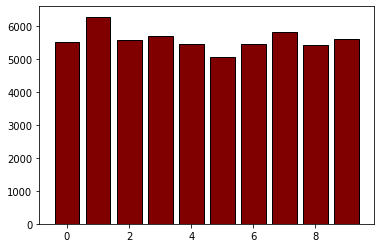

In [ ]:
Label = Table()
Label.append_column('Label', y_train)
new = Label.group('Label')
plots.bar(new.column('Label'), new.column('count'), color ='maroon')



<BarContainer object of 10 artists>

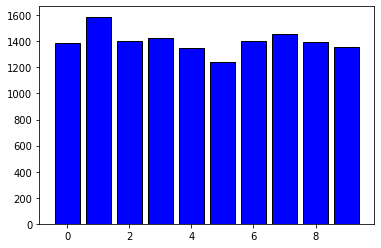

In [ ]:
Label = Table()
Label.append_column('Label', y_test)
new = Label.group('Label')
plots.bar(new.column('Label'), new.column('count'), color ='blue')

We can see that the distribution of labels is roughly the same in the training and test sets.

# Part 3: Training

Now that our training and test sets are ready, we can train a neural network to perform image recognition, specifically, to recognize handwritten digits. In this assignment, we will use a simple feed-forward network with only one hidden layer:

In [ ]:
from sklearn.neural_network import MLPClassifier

neural_network = MLPClassifier(hidden_layer_sizes=(5))
neural_network.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=5)

Training this model takes only a minute or so since the model is really simple: it consists of only 5 hidden neurons. Applying the model to our test set takes even less time:

In [ ]:
y_pred = neural_network.predict(X_test)

### Neural Network Training 

I will train a neural network with **400** hidden neurons on `X_train` and `y_train`, apply it to `X_test` to obtain predicted labels `y_pred`, and calculate and print the accuracy of the predictions by comparing `y_pred` to `y_test`. Training should take around 5 minutes (or less) depending on the platform.


In [ ]:
neural_network = MLPClassifier(hidden_layer_sizes=(400), activation='logistic', random_state=0)
neural_network.fit(X_train, y_train)
y_predicted = neural_network.predict(X_test)
accuracy = sum(y_test == y_predicted) / len(y_predicted)
print("Accuracy:", accuracy)
print("Error:", (1 - accuracy) * 100, "%")

Accuracy: 0.981
Error: 1.9 %


# Part 4: Evaluation

Beyond measuring simple accuracy, we may also be interested in the typical mistakes that our classifier makes. A standard way of displaying this information is using a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) (we need make sure that the predictions `y_pred` are from the larger, more accurate model that we trained):

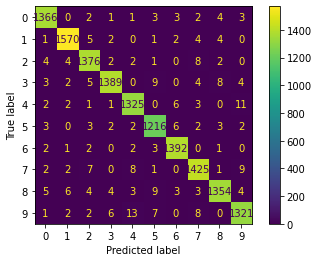

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

The rows of the confusion matrix represent the actual (true) labels, while the columns represent the predicted labels (from our classifier). The diagonal, where the actual and predicted labels are the same, represents correct predictions. The numbers show how many test examples fall into each category. For example, the first number in the first row is the number of test examples where both the actual and predicted label are 0; the second number in the first row is the number of examples where the actual label is 0, but the predicted label is 1; the first number in the second row is the number of test examples where the actual label is 1, but the predicted label is 0; and so on.

Fortunately, the highest number in each row is on the diagonal, which means that most test examples are correctly recognized by our model. The confusion matrix can help us identify which digits are difficult to recognize, and what the typical mistakes are.

### Finding and Displaying Misclassified Digits 

Let's take a look at the test examples that confused our model the most.

First, lets find the highest off-diagonal number in the confusion matrix 

Second, lets write the code to iterate over the test set and display the image



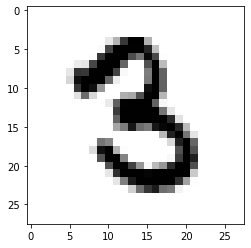

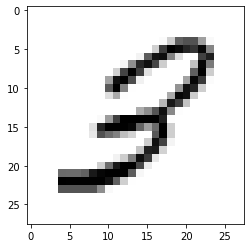

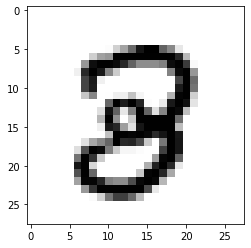

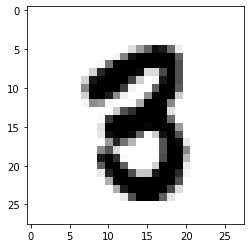

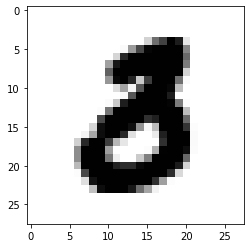

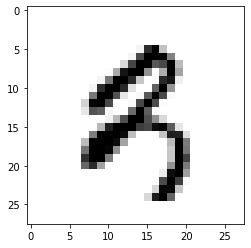

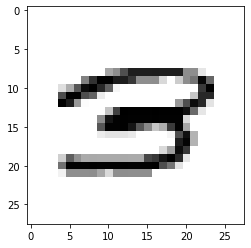

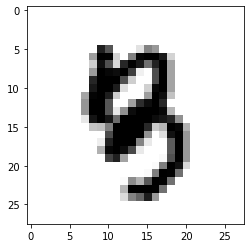

In [ ]:

actual_label = 3
predicted_label = 8
for i in np.arange(len(y_test)):
  if y_test[i] == actual_label and y_pred[i] == predicted_label:
    plots.imshow(X_test[i].reshape(28, 28), cmap='binary')
    plots.show()




# Part 5: Comparison

We conclude this by comparing our neural network with two other models: an XGBoost decision tree and a *k*-nearest neighbor classifier.

### Comparison with Other Classifiers

Lets train an XGBoost and a *k*-nearest neighbor classifier using scikit-learn on `X_train` and `y_train`, then apply them to `X_test` and `y_test` to obtain predictions `y_pred`, and calculate and print the accuracy of the classifiers (by comparing `y_pred` to `y_test`).

In [ ]:
# XGboost
from xgboost import XGBClassifier
xgboost_model = XGBClassifier(n_estimators=50)
xgboost_model.fit(X_train, y_train)
y_predicted = xgboost_model.predict(X_test)
accuracy = sum(y_test == y_predicted) / len(y_predicted)
print("Accuracy:", accuracy)
print("Error:", (1 - accuracy) * 100, "%")

Accuracy: 0.905
Error: 9.5 %


In [ ]:
# K-NN
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_predicted = knn_model.predict(X_test)
accuracy = sum(y_test == y_predicted) / len(y_predicted)
print("Accuracy:", accuracy)
print("Error:", (1 - accuracy) * 100, "%")

Accuracy: 0.972214285714
Error: 2.77857142857 %
